# *JunoCam* image mosaicing
This notebook is an example of mosaicing/stacking multiple images from the same perijove pass onto the same lat/lon grid. For an example of projecting single images, see the `projection.ipynb` notebook. That example also covers some of the prerequesites for running the code (e.g., SPICE kernels, etc.). In this example, we'll use two projected images from PJ27 (IDs 8724 and 8761). It is possible to mosaic all the images for a given perijove using this method but is very memory intensive. 

First, we will import the necessary packages (just like the single image example)

In [1]:
import sys, os
sys.path.append('/home/rsankar/JunoCamProjection/')
from projection import projector
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

KERNEL_DATAFOLDER = '/home/rsankar/kernels/'

Now, we will need to project each of the images we want to mosaic onto a lat/lon grid. First, we will process the raw images and get a lat/lon value for each pixel in the image. This is the same as in the single image processing example; it's repeated for each image. 

If you already ran the `projection.ipynb` code, then we can just use the existing data. The `if` statement checks whether the output already exists. We're going to add the filenames to a list so that we can use it later.

In [2]:
files = []
for ID in ['8724', '8761']:
    proj = projector.Projector("ImageSet/", f"DataSet/{ID}-Metadata.json", KERNEL_DATAFOLDER)
    # add the filename of the output to a list to use later
    files.append(proj.fname+".nc")
    if not os.path.isfile(f'nc/{proj.fname}.nc'):
        proj.process(num_procs=15)

In [3]:
print(files)

['JNCE_2020154_27C00047_V01.nc', 'JNCE_2020154_27C00048_V01.nc']


Now, we can call the mosaicing code to stitch the two images together. We first need to project each image to a common lat/lon grid, which can be done using the `map_project` function as shown in the `projection.ipynb` example. 

For mosaicing purposes, we will instead use the `map_project_multi` which automatically determines the common grid between the two images, and then calls `map_project` on each image. Additionally, `map_project_multi` requires some method for correcting the lighting differences between the two images, which are detailed in `projection.ipynb`. Here, we are going to use the FFT method. 

The main input here is the `combine_method` parameter. This is an argument that decides how the images should be stacked. There are a few options: 

 - 'max': The final image is a pixel-wise maximum of all images
 - 'min': The final image is a pixel-wise minimum of all images
 - 'box_average': Creates a box (50x50 pixels) which slides across the entire image and calculates a brightness weight for each box for each image. The final image is a weighted mean across all images which ensure that all boxes have the same average brightness. This is the usually the most robust method, but more computationally expensive than the other two. 
 
In the below example, we will use the `fft` correction and the `box_average` method. As before, we will leverage multiprocessing to speed up the process. By default, the processed data will be saved in `nc/multi_proj_raw.nc`, but this can be changed with the `outfile` parameter. 

**Note: this process will take more than 15-20 mins!**

In [4]:
resolution=25 ## pixels/degree
lon, lat, IMG = projector.map_project_multi(files, pixres=1./resolution,
                                            scorr_method='fft', fft_radius=7, trim_rad=1.1, trim_threshold=0.98,
                                            combine_method='box_average', num_procs=15)

Extents - lon: -93.986 93.896  lat: -88.608 1.832
Mosaic shape: 4698 x 2261
Projecting JNCE_2020154_27C00047_V01
Using raw IMG
Limits: lon: -84.087 90.713  lat: -80.006 1.794  size: 4371 x 2046
 2000/2046 Processing B
 19/20
[=================== ] 98.25%
Processing G
 19/20
[=================== ] 96.49%
Processing R
 19/20
[=================== ] 98.23%
Processing emission angles
 19/20
[=================== ] 98.27%
Processing incidence angles
 19/20
[=================== ] 98.27%
Interpolating from 2046 x 4371 => 2261 x 4698
Trimming: [=================== ] 2258/2261
Projecting JNCE_2020154_27C00048_V01
Using raw IMG
Limits: lon: -93.986 93.894  lat: -88.608 0.392  size: 4698 x 2226

 2200/2226 Processing B
 19/20
[=================== ] 98.01%
Processing G
 19/20
[=================== ] 98.01%
Processing R
 19/20
[=================== ] 98.33%
Processing emission angles
 19/20
[=================== ] 98.11%
Processing incidence angles
 19/20
[=================== ] 96.21%
Interpolating from

Let's plot this out to see what it looks like

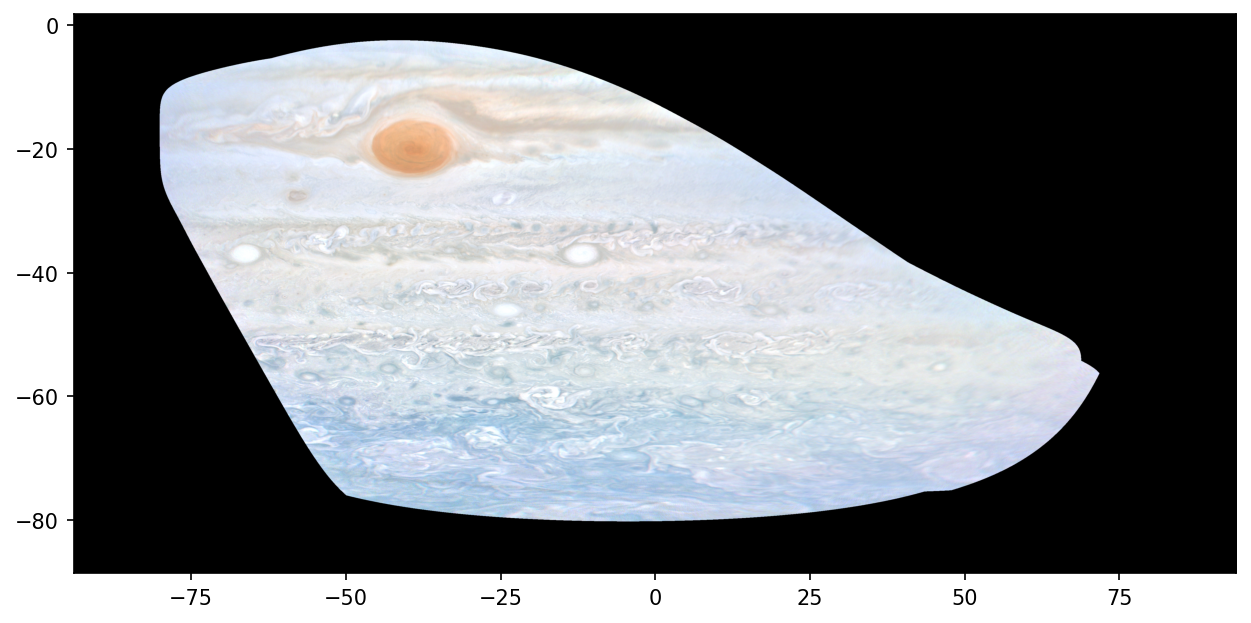

In [5]:
plt.figure(figsize=(10, 5), dpi=150)
plt.imshow(IMG, extent=(lon.min(), lon.max(), lat.min(), lat.max()), origin='lower')
plt.show()

As before, we can do some color correction on this image:

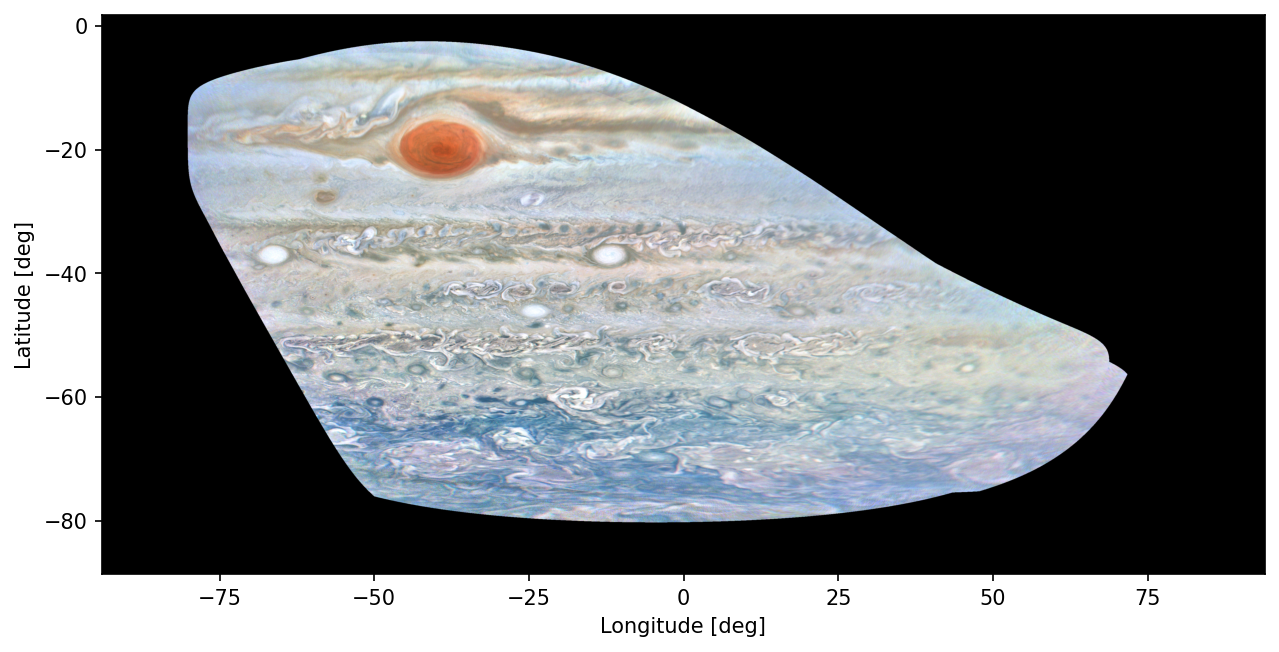

In [6]:
IMG_corr = projector.color_correction("nc/multi_proj_raw.nc", gamma=1.1, hist_eq=True, clip_limit=0.008, 
                                      fname="GRS", save=True)

We can also test out the other parameters. For example, with a higher `fft_radius` we can see that some of the sharper features are losing their distinction. Since we already processed the data before (and we are not changing resolution), we can simply load the previous data instead of re-projecting each image (using the `load=True` argument)

In [7]:
resolution=25 ## pixels/degree
lon, lat, IMG = projector.map_project_multi(files, outfile='mosaic_fft20.nc', pixres=1./resolution, load=True,
                                            scorr_method='fft', fft_radius=20, trim_rad=1.1, trim_threshold=0.98,
                                            combine_method='box_average', num_procs=15)

Extents - lon: -93.986 93.896  lat: -88.608 1.832
Mosaic shape: 4698 x 2261
Projecting JNCE_2020154_27C00047_V01
Using raw IMG
Limits: lon: -84.087 90.713  lat: -80.006 1.794  size: 4371 x 2046
Loading mask file
Processing B
Loading from ./npy/JNCE_2020154_27C00047_V01_B.npy
Processing G
Loading from ./npy/JNCE_2020154_27C00047_V01_G.npy
Processing R
Loading from ./npy/JNCE_2020154_27C00047_V01_R.npy
Loading emission data
Loading incidence data
Interpolating from 2046 x 4371 => 2261 x 4698
Trimming: [=================== ] 2258/2261
Projecting JNCE_2020154_27C00048_V01
Using raw IMG
Limits: lon: -93.986 93.894  lat: -88.608 0.392  size: 4698 x 2226
Loading mask file
Processing B
Loading from ./npy/JNCE_2020154_27C00048_V01_B.npy
Processing G
Loading from ./npy/JNCE_2020154_27C00048_V01_G.npy
Processing R
Loading from ./npy/JNCE_2020154_27C00048_V01_R.npy
Loading emission data
Loading incidence data
Interpolating from 2226 x 4698 => 2261 x 4698
Trimming: [=================== ] 2258/2261


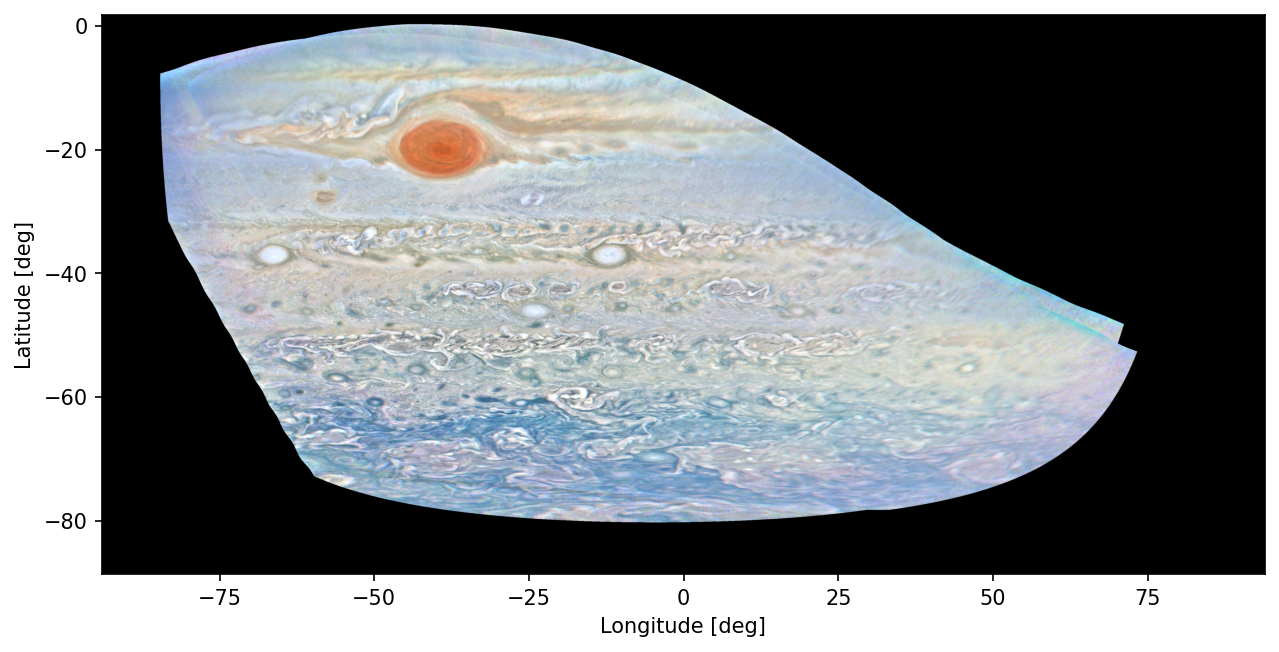

In [8]:
IMG_corr = projector.color_correction("nc/mosaic_fft20.nc", gamma=1.1, hist_eq=True, clip_limit=0.008, 
                                      fname="GRS_fft20", save=True)